# Purpose

Initial:
- Get a framework to visualize ARK investing data (Ex: What are they buying/selling, what sectors?)

To-do List:
- Date is currently a string causing `1/8` to be larger than `1/11` <br>
    -__CANNOT__ fix at the source (ie: `update_arkfunds` database) because sqlite3 does not have a datetime format to save into (Only text, int, real).
    - Solution is to convert to datetime as needed (in the individual functions that require it)
- `ticker_lookup` errors for `FATE` ... need to probably generate df[df['ticker']] instead of df[(df[date])&(df[ticker])]
    - By subsetting to ticker specific -- can then extract the dates to standardize the X-axis (which prevets the current issue)
- `Change_in_portfolio` computes changes + new positions + closed positions ... however the date of a new position would be great (as well as date of a closed position)
- Micro/Small/Mid/Large cap designations for all tickers
- Create an alert system for Micro/Small cap investments

End game is to answer questions:
- Alerts when they buy penny stocks (Lo-cap)
     - May need FinViz connection
- Statistics on the follow:
    - How much is the average drawdown of a position?
    - How long does it take (on average) for a position to be decently positive (>10%)?
    - ???

In [7]:
def set_dir(path = r"C:\Users\Brandon\Desktop\ARK Fund CSV Files"):
    import os
    os.chdir(path)

In [8]:
def see_data(db=0): #Function to view the data in the database easily
    import sqlite3
    import pandas as pd
    
    set_dir()
    
    if db == 0:
        db_name = "ARKFund.db"
        db_table = "arkfunds"
    elif db == 1:
        db_name = "sectors.db"
        db_table = "sectors"
        
    conn = sqlite3.connect(db_name) #Connect
    df = pd.read_sql_query('SELECT * FROM ' + db_table,conn)
    #display(df) #Print all data
    conn.close()
    return df

In [9]:
def capitalization(ticker): #Determine cap size of company
    import finviz
    try:
        info = finviz.get_stock(ticker)['Market Cap'] #Get market cap

        #Split market cap to take only whole number
        l,r = info.split('.')
        valuation = int(l) #Left of the decimal place
        units = r[-1] #Units ("M" or "B")

        #Nano is less than 50M ... dont think i need to classify this though
        #Micro is anything 300M and less
        #Small is [300M,2B]
        #Mid is [2B,10B]
        #Large is everything else
        if units == "M":
            if valuation <300:
                cap = "Micro"
            else:
                cap = "Small"
        elif units == "B":
            if valuation < 2:
                cap = "Small"
            elif valuation <= 10:
                cap = "Mid"
            else:
                cap = "Large"
        elif units == "T": #Companies like AAPL are 2151B ... but just in case finviz ever updates to trillion
            cap = "Large"
        else:
            cap = "Nano" #Catch case if something else shows up ... would have to assume Nano cap
    except:
        cap = "NA"
        valuation = "NA"
        units = ""
    return cap,str(valuation)+units #Cap = classification | MarketCap

In [10]:
def update_sectors(df):
    '''
    Function to check if any new unique tickers exist
    -- If not, do nothing
    -- If so,
    ---- Utilize finviz to find sector info for ticker
    ---- Update the sectors.db to include this unique ticker
    '''
    import finviz
    import os
    import sqlite3
    import pandas as pd

    set_dir()
    
    if "sectors.db" in os.listdir():
        #Connect to db
        conn = sqlite3.connect('sectors.db')

    else:
        #Create db
        conn = sqlite3.connect('sectors.db') #Yes ... its the same line of code to connect or create

        #Create cursor
        c = conn.cursor()

        #Define table structure
        c.execute('''CREATE TABLE sectors (ticker TEXT, sector TEXT, cap TEXT, market_cap INT)''')
        conn.commit() #save

    print("update_sectors():")
    print("\t--- Connection to sector db established ---")

    #Grab db info
    sector_tickers = pd.read_sql_query("SELECT * FROM sectors ORDER BY ticker",conn)
    
    if len(df) < 1: #No df to process
        #Find all unique tickers in the database
        data_to_process = False
    else:
        data_to_process = True
    
    if data_to_process:
        tickers = df['ticker'].unique() 

        missing = []
        print("\tChecking if tickers need updating")
        for i in tickers:
            if i not in sector_tickers['ticker'].unique():
                missing.append(i) #Add all new tickers to "missing"
                if len(missing) == 1: #If a new ticker is found, do a printout notification
                    print("\t\tNew tickers found")

        sector = []
        cap_designation = []
        valuation = []
        if len(missing) < 1:
            print("\t\tNo new tickers to update")
        else:
            print("\tSearching sector & capitalization info for %d tickers"%len(tickers))
            for i in missing: #For each ticker missing, attempt to find the sector for it
                print("\t\t"+i+" --- ",end='')
                try:
                    sec = finviz.get_stock(i)['Sector']
                    c,m = capitalization(i)
                except:
                    sec = "NA" #Some tickers like "ARCT UQ" will not pull up a result
                    c = "NA"
                    m = "NA"
                cap_designation.append(c)
                valuation.append(m)
                sector.append(sec)
                print(sec) #Attach the sector to the printout
            
        #Update the df
        sector_tickers = sector_tickers.append(pd.DataFrame({'ticker':missing,
                                                             'sector':sector,
                                                             'cap':cap_designation,
                                                             'market_cap':valuation}),ignore_index=True)

        #Format the df a bit
        sector_tickers = sector_tickers.sort_values(by='ticker').reset_index(drop=True) #sort by ticker & reset index

        #Write to db
        sector_tickers.to_sql(name='sectors', con=conn, if_exists='replace', index=False)

        conn.commit() #Save
        print("\tSector information has been updated")
    
    #Close connections   
    conn.close()
    print("\tConnection to sectors.db has been closed")
    
    return sector_tickers

In [11]:
def backup_data():
    '''
    Run every so often to backup the ARKFunds.db and Sectors.db files
    '''
    from shutil import copyfile
    import datetime
    
    set_dir() #Make sure directory is set appropriately
    
    today = datetime.datetime.today()
    
    if today.weekday() == 4: #If day of week is Friday
        print("backup_data() activated --- backing up databases because it is Friday")
        copyfile("ARKFund.db","Backups/"+today.date().isoformat()+" ARKFund.db")
        copyfile("sectors.db","Backups/"+today.date().isoformat()+" sectors.db")
        print("\tData has been backedup for today: ",today.date().isoformat())
    else:
        pass

In [12]:
def change_in_portfolio(date1=None,date2=None,fund=None,debug=False):
    '''
    Functionality for `fund` argument built in ... but not fully tested
    '''
    import numpy as np
    import pandas as pd
    
    df = see_data(0) #Grab all data in SQL database
    unique_dates = df['date'].unique()
    df['date'] = df['date'].astype('datetime64[ns]') #Convert date to datetime object
    df = df.sort_values(by='date',ascending=True).drop(['sector','market_cap','weight'],axis=1) #Sort ascending dates & drop unnecessary columns
    
    #If no dates provided
    if date1 == None or date2 == None:
        date1 = unique_dates[-2] #Previous trading session
        date2 = unique_dates[-1] #Most recent trading session
    
    #If dates provided are short-hand .... add the year to them
    def add_year(date):
        import datetime
        year = datetime.datetime.today().year
        return date+"/"+str(year)
    if len(date1)<7:
        date1 = add_year(date1)
    if len(date2)<7:
        date2 = add_year(date2)
    
    #To account for "New" positions opened... the date BEFORE date1 needs to be referenced.
    #Ex: If a new position is opened on 1/11 ... how do you know it is new unless you can confirm from 1/10 that a position was not previously held
    loc_initial_date = np.where(np.array(unique_dates)==date1)[0][0]-1 #Minus 1 to reach the previous date
    
    #If no fund provided, simply search by dates
    if fund == None:
        #Grab subset info for the dates
        a = df[(df['date']==date1)]
        b = df[(df['date']==date2)]
    else:
        #Grab subset info for the specified fund
        a = df[(df['date']==date1)&(df['fund']==fund)]
        b = df[(df['date']==date2)&(df['fund']==fund)]
    
    #Compare via `how='outer'`
    diff = a.merge(b,how='outer',on=['fund','company','ticker','cap'],indicator=False) #Determine differences between the 2 dates
    diff['change'] = diff['shares_y']-diff['shares_x'] #Compute change in shares
    diff['percent_change'] = np.round(np.divide(100*diff['change'],diff['shares_x']),2)
    
    #Pick only select columns
    #diff = diff[['date_x','date_y','fund','ticker','shares_x','shares_y','change']]
    
    #Create new DF with appropriate column headers
    changes = diff.rename(columns={'shares_x':"shares_then","shares_y":"shares_now",
                                'date_x':"start_date","date_y":"end_date"}) #Rename for clarity
    changes = changes[['start_date','end_date','fund','company','ticker','shares_then','shares_now','change','percent_change','cap']]
    
    ###Determine positions that are new
    new = changes[pd.isna(changes['shares_then'])] #All positions which didn't have shares before are new
    
    # Compute a sliced df containing only dates between [date1,date2] for use in `new` and `closed` dfs
    #Subset the original df to be between these 2 dates
    df = df[(df['date']>=unique_dates[loc_initial_date])&(df['date']<=date2)] #This new df is used to compute new & closed positions
    
    #Compute the date these positions opened
    initiation_date = []
    for i,row in new.iterrows():
        subset = df[(df['ticker']==row['ticker'])&(df['fund']==row['fund'])] #Find this subset in the sliced [date1,date2] df
        initiation_date.append(subset.iloc[0]['date'])

    new = new[['fund','ticker','shares_now']] #Drop the useless information (NaN columns)
    new['initiation_date'] = initiation_date #Create a new column with the date of position start
    new = new.sort_values(by='initiation_date',ascending=False) #Sort df by open dates
    
    ###Determine positions that closed
    closed = diff[pd.isna(diff['shares_y'])==True] #All positions which no longer have shares on today's date are closed
    display(closed)
    #Determine date the position(s) were closed
    sell_date = []
    for _,row in closed.iterrows():
        subset = df[(df['ticker']==row['ticker'])&(df['fund']==row['fund'])] #Find all instances of the closed ticker position
        sell_date.append(subset['date'].iloc[-1]) #The final entry's date is the close date

    closed = closed[['fund','ticker','shares_x']].rename(columns={'shares_x':"shares_before_sale"}) #Drop unnecessary columns
    closed['close_date'] = sell_date #Create column
    closed = closed.sort_values(by='close_date',ascending=False) #Sort data
    
    ##Update Change df to not include new or closed positions
    #The rows that would exist in "new" and "closed" are present in "changes" as well -- eliminate by finding all non-NaN entries
    changes = changes[pd.isna(changes['change'])==False] #Make the "changes" df have all changes that arent new/closed

    ##Determine what are `significant` transactions to keep an eye on
    alerts = changes.copy() #Copy the df
    changes = changes.drop(['cap','company'],axis=1) #Drop the last few columns on Change column that arent necessary
    alerts = alerts[(np.abs(alerts['percent_change'])>=10)|((np.abs(alerts['percent_change'])>=4.5)&(alerts['cap']=='Small'))].sort_values(by=['percent_change'],ascending=False).reset_index(drop=True)
    
    if debug: #Just making a quick method to print all 4 df results accordingly
        print("dates:")
        print(date1,date2)
        print("Changes:")
        display(changes)
        print("New positions:")
        display(new)
        print("Closed positions:")
        display(closed)
        print("Alerts:")
        display(alerts)
    
    return changes, new, closed, alerts

In [13]:
def update_capitalization(manual_update=False):
    """
    Function to update capitalization & market cap for ALL stocks in the database
    Recommend running once in a while ... maybe once a week?
    
    Why run this?
    Companies may break the barrier from Small -> Mid or drop from Mid -> Small (since the bound is only 2B to 10B for small)
    """
    import pandas as pd
    import numpy as np
    import sqlite3
    import datetime
    
    today = datetime.datetime.today().weekday()
    #today = 4 #For debug testing, set value to 4 manually
    if today == 4 or manual_update==True:
        print("update_capitalization():")
        print("\tUpdating capitalization information for entire database")
        conn = sqlite3.connect("ARKFund.db")
        conn2 = sqlite3.connect("sectors.db")
        df = pd.read_sql_query("SELECT * FROM arkfunds",conn)
        print("\tConnection to ARKFund.db established")
        sectors = pd.read_sql_query("SELECT * FROM sectors",conn2)
        print("\tConnection to sectors.db established")

        #Create placeholder lists
        c = [] #Cap designation (Eg: Small)
        m = [] #Market cap value (Eg: 1B)

        count = 0
        total = len(sectors['ticker'])
        print("\tUpdating %s tickers:"%total)
        for i in sectors['ticker']:
            if count%40 == 0: #Every 40 rows, update the progress
                print("\t\t%.2f/100%%"%(np.round(count/total,2)*100))
            try:
                cap_designation,market_cap = capitalization(i)
            except:
                cap_designation,market_cap = ["NA","NA"]
            c.append(cap_designation)
            m.append(market_cap)
            count += 1

        print("\t\tDone finding capitalizations -- Merging to `sectors` database")
        sectors['cap'] = c
        sectors['market_cap'] = m

        print("\tWriting results to sectors.db")
        sectors.to_sql(name='sectors',con=conn2,if_exists='replace',index=False)
        print("\t\tSectors.db updated successfully")

        #Create dictionaries to map (Ticker --> Cap) and (Ticker --> Market_cap)
        dct_cap = dict(sectors[['ticker','cap']].to_dict('split')['data']) # dct of {'AAPL':'Large', ... , 'ZM':'Large'}
        dct_market_cap = dict(sectors[['ticker','market_cap']].to_dict('split')['data']) #dct of {'AAPL':'2180B', ... , 'ZM':'114B'}

        df = df.drop(['cap','market_cap'],axis=1) #Drop the cap and market_cap columns because we'll be updating them
        
        #Re-create the columns via mapping
        df['cap'] = df['ticker'].map(dict(dct_cap))
        df['market_cap'] = df['ticker'].map(dict(dct_market_cap))

        print("\tWriting results to ARKFunds.db")
        df.to_sql(name='arkfunds', con=conn, if_exists="replace", index=False)
        print("\t\tARKFund.db updated successfully")

        #Now actually save the data (even though printouts have been saying its been successful)
        conn.commit()
        conn2.commit()

        conn.close()
        conn2.close()
        print("\tDatabase connections closed successfully")
    else:
        pass #Dont execute unless it's Friday

In [14]:
def update_arkfund(display_changes=False):
    import glob
    import os
    import sqlite3
    import pandas as pd
    import finviz
    
    #Change directory
    set_dir()

    #Load all excel files & Concat together
    files = glob.glob("*.csv") #Find all

    if "ARKFund.db" in os.listdir():
        #Connect to db
        conn = sqlite3.connect('ARKFund.db')

        #Create cursor object
        c = conn.cursor()
    else:
        #Create db
        conn = sqlite3.connect('ARKFund.db') #Yes ... its the same line of code to connect or create

        #Create cursor
        c = conn.cursor()

        #Define table structure
        c.execute('''CREATE TABLE arkfunds 
            (date TEXT, fund TEXT, company TEXT, ticker TEXT, shares INTEGER, weight REAL, sector TEXT,cap TEXT, market_cap INT)
                ''')
        conn.commit() #save

    print("--- Connection to ARKFunds.db established ---")

    print("Processing %.0f files:"%len(files))

    existing_files = glob.glob("Processed\*.csv")
    existing_files = [i[10:] for i in existing_files]
    
    df_all = pd.DataFrame()
    new_data=False #Set default switch
    for file in files:
        if file not in existing_files:
            df = pd.read_csv(file) #Read csv file
            df_all = df_all.append(df) #Append to mega df
            new_data=True
            
    if new_data: #If there is data to process
        #Grab sector info
        #1) Check if there are any new unique tickers that havent existed before
        #2) Grab the info if new tickers
        sectors = update_sectors(df_all) #Use the function to update any ticker that didnt exist AND obtain df of [ticker,sector]
        
        #Match "Ticker" in arkfunds.db to "sector" from sectors.db
        sec = []
        for i in df_all['ticker']:
            try:
                sec.append(sectors[sectors['ticker']==i]['sector'].iloc[0])
            except:
                sec.append("NA")
        print("Updating ARKfund with Sector.db info")
        df_all['sector'] = sec #create a new column called "sector" by matching the `ticker` to `sector`
        
        #Convert date column into datetime object 
        #df_all['date'] = df_all['date'].astype("datetime64[ns]") 
        ###Does not work! -- SQLite3 can only accept types TEXT, INT, REAL ... this results in datetime --> TEXT upon saving
        
        print("Computing capitalization of new data")
        #Do this by loading in sectors.db data and grabbing the data from there (already loaded as sectors)
        cap_designation = []
        valuation = []
        count = 2
        total = len(df_all['ticker'])
        for i in df_all['ticker']: 
            if count%50 == 0 or count == total: #Provide progress updates
                print("\t%s/%s"%(count,total))
            temp = sectors[sectors['ticker']==i]
            cap_designation.append(temp['cap'].iloc[0])
            valuation.append(temp['market_cap'].iloc[0])
            count += 1
        
        df_all['cap'] = cap_designation
        df_all['market_cap'] = valuation
        
        #Rename 'weight(%)' to 'weight'
        print("Renaming weight(%) to weight")
        df_all = df_all.rename(columns={"weight(%)":"weight"})

        #Update ARKFunds.db database
        print("Writing results to database")
        df_all.to_sql(name='arkfunds', con=conn, if_exists='append', index=False)

        conn.commit() #Save database
        
        #Now that all the work has been done, move the files (do this last to avoid double entry of files)
        for file in files:
            if file not in existing_files:    
                os.rename(file, "Processed/"+file) #Move csv file to the processed folder so it doesn't read next time
                print("\t%s has been uploaded"%file)
            else:
                print("\t%s already exists in the database -- Removing file"%file)
                os.remove(file)
                print("File: %s has been deleted"%file)
    else:
        print("No new data to process")
        sectors = see_data(1) #Grab sectors data to provide as output

    conn.close() #Close SQLite Database connection
    print("--- Connection closed ---")
    print("SQL Database has been successfully updated.")
    
    #Backup servers as necessary (Current trigger is: Friday (weekday == 4))
    update_capitalization() #Updates all info for sectors.db then ARKFund.db ... a bit redundant because we just loaded data today (but runs quite fast)
    backup_data() #function checks weekday and returns nothing if weekday != 4 ... it backs up both ".db" files
        
    _, new, closed, alerts = change_in_portfolio() #Determine changes, new positions, closed positions, alerts
    if display_changes:
        print("New positions:")
        display(new)
        print("Closed positions:")
        display(closed)
        print("Alerts:")
        display(alerts)
        
    return df_all,sectors, new, closed, alerts #df_all = df of newly appended data .. NOT the data in arkfunds.db | sectors = sector all info from sectors.db

Write all functions to a .py file to import and use 

In [15]:
%%writefile ARK.py
def set_dir(path = r"C:\Users\Brandon\Desktop\ARK Fund CSV Files"):
    import os
    os.chdir(path)

def see_data(db=0): #Function to view the data in the database easily
    import sqlite3
    import pandas as pd
    
    set_dir()
    
    if db == 0:
        db_name = "ARKFund.db"
        db_table = "arkfunds"
    elif db == 1:
        db_name = "sectors.db"
        db_table = "sectors"
        
    conn = sqlite3.connect(db_name) #Connect
    df = pd.read_sql_query('SELECT * FROM ' + db_table,conn)
    #display(df) #Print all data
    conn.close()
    return df

def capitalization(ticker): #Determine cap size of company
    import finviz
    try:
        info = finviz.get_stock(ticker)['Market Cap'] #Get market cap

        #Split market cap to take only whole number
        l,r = info.split('.')
        valuation = int(l) #Left of the decimal place
        units = r[-1] #Units ("M" or "B")

        #Nano is less than 50M ... dont think i need to classify this though
        #Micro is anything 300M and less
        #Small is [300M,2B]
        #Mid is [2B,10B]
        #Large is everything else
        if units == "M":
            if valuation <300:
                cap = "Micro"
            else:
                cap = "Small"
        elif units == "B":
            if valuation < 2:
                cap = "Small"
            elif valuation <= 10:
                cap = "Mid"
            else:
                cap = "Large"
        elif units == "T": #Companies like AAPL are 2151B ... but just in case finviz ever updates to trillion
            cap = "Large"
        else:
            cap = "Nano" #Catch case if something else shows up ... would have to assume Nano cap
    except:
        cap = "NA"
        valuation = "NA"
        units = ""
    return cap,str(valuation)+units #Cap = classification | MarketCap    

def update_sectors(df):
    '''
    Function to check if any new unique tickers exist
    -- If not, do nothing
    -- If so,
    ---- Utilize finviz to find sector info for ticker
    ---- Update the sectors.db to include this unique ticker
    '''
    import finviz
    import os
    import sqlite3
    import pandas as pd

    set_dir()
    
    if "sectors.db" in os.listdir():
        #Connect to db
        conn = sqlite3.connect('sectors.db')

    else:
        #Create db
        conn = sqlite3.connect('sectors.db') #Yes ... its the same line of code to connect or create

        #Create cursor
        c = conn.cursor()

        #Define table structure
        c.execute('''CREATE TABLE sectors (ticker TEXT, sector TEXT, cap TEXT, market_cap INT)''')
        conn.commit() #save

    print("update_sectors():")
    print("\t--- Connection to sector db established ---")

    #Grab db info
    sector_tickers = pd.read_sql_query("SELECT * FROM sectors ORDER BY ticker",conn)
    
    if len(df) < 1: #No df to process
        #Find all unique tickers in the database
        data_to_process = False
    else:
        data_to_process = True
    
    if data_to_process:
        tickers = df['ticker'].unique() 

        missing = []
        print("\tChecking if tickers need updating")
        for i in tickers:
            if i not in sector_tickers['ticker'].unique():
                missing.append(i) #Add all new tickers to "missing"
                if len(missing) == 1: #If a new ticker is found, do a printout notification
                    print("\t\tNew tickers found")

        sector = []
        cap_designation = []
        valuation = []
        if len(missing) < 1:
            print("\t\tNo new tickers to update")
        else:
            print("\tSearching sector & capitalization info for %d tickers"%len(tickers))
            for i in missing: #For each ticker missing, attempt to find the sector for it
                print("\t\t"+i+" --- ",end='')
                try:
                    sec = finviz.get_stock(i)['Sector']
                    c,m = capitalization(i)
                except:
                    sec = "NA" #Some tickers like "ARCT UQ" will not pull up a result
                    c = "NA"
                    m = "NA"
                cap_designation.append(c)
                valuation.append(m)
                sector.append(sec)
                print(sec) #Attach the sector to the printout
            
        #Update the df
        sector_tickers = sector_tickers.append(pd.DataFrame({'ticker':missing,
                                                             'sector':sector,
                                                             'cap':cap_designation,
                                                             'market_cap':valuation}),ignore_index=True)

        #Format the df a bit
        sector_tickers = sector_tickers.sort_values(by='ticker').reset_index(drop=True) #sort by ticker & reset index

        #Write to db
        sector_tickers.to_sql(name='sectors', con=conn, if_exists='replace', index=False)

        conn.commit() #Save
        print("\tSector information has been updated")
    
    #Close connections   
    conn.close()
    print("\tConnection to sectors.db has been closed")
    
    return sector_tickers     #Update sectors.db

def backup_data():
    '''
    Run every so often to backup the ARKFunds.db and Sectors.db files
    '''
    from shutil import copyfile
    import datetime
    
    set_dir() #Make sure directory is set appropriately
    
    today = datetime.datetime.today()
    
    if today.weekday() == 4: #If day of week is Friday
        print("backup_data() activated --- backing up databases because it is Friday")
        copyfile("ARKFund.db","Backups/"+today.date().isoformat()+" ARKFund.db")
        copyfile("sectors.db","Backups/"+today.date().isoformat()+" sectors.db")
        print("\tData has been backedup for today: ",today.date().isoformat())
    else:
        pass     #Backup both ".db" files (executes on Friday)

def change_in_portfolio(date1=None,date2=None,fund=None,debug=False):
    '''
    Functionality for `fund` argument built in ... but not fully tested
    '''
    import numpy as np
    import pandas as pd
    
    df = see_data(0) #Grab all data in SQL database
    unique_dates = df['date'].unique()
    df['date'] = df['date'].astype('datetime64[ns]') #Convert date to datetime object
    df = df.sort_values(by='date',ascending=True).drop(['sector','market_cap','weight'],axis=1) #Sort ascending dates & drop unnecessary columns
    
    #If no dates provided
    if date1 == None or date2 == None:
        date1 = unique_dates[-2] #Previous trading session
        date2 = unique_dates[-1] #Most recent trading session
    
    #If dates provided are short-hand .... add the year to them
    def add_year(date):
        import datetime
        year = datetime.datetime.today().year
        return date+"/"+str(year)
    if len(date1)<7:
        date1 = add_year(date1)
    if len(date2)<7:
        date2 = add_year(date2)
    
    #To account for "New" positions opened... the date BEFORE date1 needs to be referenced.
    #Ex: If a new position is opened on 1/11 ... how do you know it is new unless you can confirm from 1/10 that a position was not previously held
    loc_initial_date = np.where(np.array(unique_dates)==date1)[0][0]-1 #Minus 1 to reach the previous date
    
    #If no fund provided, simply search by dates
    if fund == None:
        #Grab subset info for the dates
        a = df[(df['date']==date1)]
        b = df[(df['date']==date2)]
    else:
        #Grab subset info for the specified fund
        a = df[(df['date']==date1)&(df['fund']==fund)]
        b = df[(df['date']==date2)&(df['fund']==fund)]
    
    #Compare via `how='outer'`
    diff = a.merge(b,how='outer',on=['fund','company','ticker','cap'],indicator=False) #Determine differences between the 2 dates
    diff['change'] = diff['shares_y']-diff['shares_x'] #Compute change in shares
    diff['percent_change'] = np.round(np.divide(100*diff['change'],diff['shares_x']),2)
    
    #Pick only select columns
    #diff = diff[['date_x','date_y','fund','ticker','shares_x','shares_y','change']]
    
    #Create new DF with appropriate column headers
    changes = diff.rename(columns={'shares_x':"shares_then","shares_y":"shares_now",
                                'date_x':"start_date","date_y":"end_date"}) #Rename for clarity
    changes = changes[['start_date','end_date','fund','company','ticker','shares_then','shares_now','change','percent_change','cap']]
    
    ###Determine positions that are new
    new = changes[pd.isna(changes['shares_then'])] #All positions which didn't have shares before are new
    
    # Compute a sliced df containing only dates between [date1,date2] for use in `new` and `closed` dfs
    #Subset the original df to be between these 2 dates
    df = df[(df['date']>=unique_dates[loc_initial_date])&(df['date']<=date2)] #This new df is used to compute new & closed positions
    
    #Compute the date these positions opened
    initiation_date = []
    for i,row in new.iterrows():
        subset = df[(df['ticker']==row['ticker'])&(df['fund']==row['fund'])] #Find this subset in the sliced [date1,date2] df
        initiation_date.append(subset.iloc[0]['date'])

    new = new[['fund','ticker','shares_now']] #Drop the useless information (NaN columns)
    new['initiation_date'] = initiation_date #Create a new column with the date of position start
    new = new.sort_values(by='initiation_date',ascending=False) #Sort df by open dates
    
    ###Determine positions that closed
    closed = diff[pd.isna(diff['shares_y'])==True] #All positions which no longer have shares on today's date are closed
    display(closed)
    #Determine date the position(s) were closed
    sell_date = []
    for _,row in closed.iterrows():
        subset = df[(df['ticker']==row['ticker'])&(df['fund']==row['fund'])] #Find all instances of the closed ticker position
        sell_date.append(subset['date'].iloc[-1]) #The final entry's date is the close date

    closed = closed[['fund','ticker','shares_x']].rename(columns={'shares_x':"shares_before_sale"}) #Drop unnecessary columns
    closed['close_date'] = sell_date #Create column
    closed = closed.sort_values(by='close_date',ascending=False) #Sort data
    
    ##Update Change df to not include new or closed positions
    #The rows that would exist in "new" and "closed" are present in "changes" as well -- eliminate by finding all non-NaN entries
    changes = changes[pd.isna(changes['change'])==False] #Make the "changes" df have all changes that arent new/closed

    ##Determine what are `significant` transactions to keep an eye on
    alerts = changes.copy() #Copy the df
    changes = changes.drop(['cap','company'],axis=1) #Drop the last few columns on Change column that arent necessary
    alerts = alerts[(np.abs(alerts['percent_change'])>=10)|((np.abs(alerts['percent_change'])>=4.5)&(alerts['cap']=='Small'))].sort_values(by=['percent_change'],ascending=False).reset_index(drop=True)
    
    if debug: #Just making a quick method to print all 4 df results accordingly
        print("dates:")
        print(date1,date2)
        print("Changes:")
        display(changes)
        print("New positions:")
        display(new)
        print("Closed positions:")
        display(closed)
        print("Alerts:")
        display(alerts)
    
    return changes, new, closed, alerts
    
def update_capitalization(manual_update=False):
    """
    Function to update capitalization & market cap for ALL stocks in the database
    Recommend running once in a while ... maybe once a week?
    
    Why run this?
    Companies may break the barrier from Small -> Mid or drop from Mid -> Small (since the bound is only 2B to 10B for small)
    """
    import pandas as pd
    import numpy as np
    import sqlite3
    import datetime
    
    today = datetime.datetime.today().weekday()
    #today = 4 #For debug testing, set value to 4 manually
    if today == 4 or manual_update==True:
        print("update_capitalization():")
        print("\tUpdating capitalization information for entire database")
        conn = sqlite3.connect("ARKFund.db")
        conn2 = sqlite3.connect("sectors.db")
        df = pd.read_sql_query("SELECT * FROM arkfunds",conn)
        print("\tConnection to ARKFund.db established")
        sectors = pd.read_sql_query("SELECT * FROM sectors",conn2)
        print("\tConnection to sectors.db established")

        #Create placeholder lists
        c = [] #Cap designation (Eg: Small)
        m = [] #Market cap value (Eg: 1B)

        count = 0
        total = len(sectors['ticker'])
        print("\tUpdating %s tickers:"%total)
        for i in sectors['ticker']:
            if count%40 == 0: #Every 40 rows, update the progress
                print("\t\t%.2f/100%%"%(np.round(count/total,2)*100))
            try:
                cap_designation,market_cap = capitalization(i)
            except:
                cap_designation,market_cap = ["NA","NA"]
            c.append(cap_designation)
            m.append(market_cap)
            count += 1

        print("\t\tDone finding capitalizations -- Merging to `sectors` database")
        sectors['cap'] = c
        sectors['market_cap'] = m

        print("\tWriting results to sectors.db")
        sectors.to_sql(name='sectors',con=conn2,if_exists='replace',index=False)
        print("\t\tSectors.db updated successfully")

        #Create dictionaries to map (Ticker --> Cap) and (Ticker --> Market_cap)
        dct_cap = dict(sectors[['ticker','cap']].to_dict('split')['data']) # dct of {'AAPL':'Large', ... , 'ZM':'Large'}
        dct_market_cap = dict(sectors[['ticker','market_cap']].to_dict('split')['data']) #dct of {'AAPL':'2180B', ... , 'ZM':'114B'}

        df = df.drop(['cap','market_cap'],axis=1) #Drop the cap and market_cap columns because we'll be updating them
        
        #Re-create the columns via mapping
        df['cap'] = df['ticker'].map(dict(dct_cap))
        df['market_cap'] = df['ticker'].map(dict(dct_market_cap))

        print("\tWriting results to ARKFunds.db")
        df.to_sql(name='arkfunds', con=conn, if_exists="replace", index=False)
        print("\t\tARKFund.db updated successfully")

        #Now actually save the data (even though printouts have been saying its been successful)
        conn.commit()
        conn2.commit()

        conn.close()
        conn2.close()
        print("\tDatabase connections closed successfully")
    else:
        pass #Dont execute unless it's Friday

def update_arkfund(display_changes=False):
    import glob
    import os
    import sqlite3
    import pandas as pd
    import finviz
    
    #Change directory
    set_dir()

    #Load all excel files & Concat together
    files = glob.glob("*.csv") #Find all

    if "ARKFund.db" in os.listdir():
        #Connect to db
        conn = sqlite3.connect('ARKFund.db')

        #Create cursor object
        c = conn.cursor()
    else:
        #Create db
        conn = sqlite3.connect('ARKFund.db') #Yes ... its the same line of code to connect or create

        #Create cursor
        c = conn.cursor()

        #Define table structure
        c.execute('''CREATE TABLE arkfunds 
            (date TEXT, fund TEXT, company TEXT, ticker TEXT, shares INTEGER, weight REAL, sector TEXT,cap TEXT, market_cap INT)
                ''')
        conn.commit() #save

    print("--- Connection to ARKFunds.db established ---")

    print("Processing %.0f files:"%len(files))

    existing_files = glob.glob("Processed\*.csv")
    existing_files = [i[10:] for i in existing_files]
    
    df_all = pd.DataFrame()
    new_data=False #Set default switch
    for file in files:
        if file not in existing_files:
            df = pd.read_csv(file) #Read csv file
            df_all = df_all.append(df) #Append to mega df
            new_data=True
            
    if new_data: #If there is data to process
        #Grab sector info
        #1) Check if there are any new unique tickers that havent existed before
        #2) Grab the info if new tickers
        sectors = update_sectors(df_all) #Use the function to update any ticker that didnt exist AND obtain df of [ticker,sector]
        
        #Match "Ticker" in arkfunds.db to "sector" from sectors.db
        sec = []
        for i in df_all['ticker']:
            try:
                sec.append(sectors[sectors['ticker']==i]['sector'].iloc[0])
            except:
                sec.append("NA")
        print("Updating ARKfund with Sector.db info")
        df_all['sector'] = sec #create a new column called "sector" by matching the `ticker` to `sector`
        
        #Convert date column into datetime object 
        #df_all['date'] = df_all['date'].astype("datetime64[ns]") 
        ###Does not work! -- SQLite3 can only accept types TEXT, INT, REAL ... this results in datetime --> TEXT upon saving
        
        print("Computing capitalization of new data")
        #Do this by loading in sectors.db data and grabbing the data from there (already loaded as sectors)
        cap_designation = []
        valuation = []
        count = 2
        total = len(df_all['ticker'])
        for i in df_all['ticker']: 
            if count%50 == 0 or count == total: #Provide progress updates
                print("\t%s/%s"%(count,total))
            temp = sectors[sectors['ticker']==i]
            cap_designation.append(temp['cap'].iloc[0])
            valuation.append(temp['market_cap'].iloc[0])
            count += 1
        
        df_all['cap'] = cap_designation
        df_all['market_cap'] = valuation
        
        #Rename 'weight(%)' to 'weight'
        print("Renaming weight(%) to weight")
        df_all = df_all.rename(columns={"weight(%)":"weight"})

        #Update ARKFunds.db database
        print("Writing results to database")
        df_all.to_sql(name='arkfunds', con=conn, if_exists='append', index=False)

        conn.commit() #Save database
        
        #Now that all the work has been done, move the files (do this last to avoid double entry of files)
        for file in files:
            if file not in existing_files:    
                os.rename(file, "Processed/"+file) #Move csv file to the processed folder so it doesn't read next time
                print("\t%s has been uploaded"%file)
            else:
                print("\t%s already exists in the database -- Removing file"%file)
                os.remove(file)
                print("File: %s has been deleted"%file)
    else:
        print("No new data to process")
        sectors = see_data(1) #Grab sectors data to provide as output

    conn.close() #Close SQLite Database connection
    print("--- Connection closed ---")
    print("SQL Database has been successfully updated.")
    
    #Backup servers as necessary (Current trigger is: Friday (weekday == 4))
    update_capitalization() #Updates all info for sectors.db then ARKFund.db ... a bit redundant because we just loaded data today (but runs quite fast)
    backup_data() #function checks weekday and returns nothing if weekday != 4 ... it backs up both ".db" files
        
    _, new, closed, alerts = change_in_portfolio() #Determine changes, new positions, closed positions, alerts
    if display_changes:
        print("New positions:")
        display(new)
        print("Closed positions:")
        display(closed)
        print("Alerts:")
        display(alerts)
        
    return df_all,sectors, new, closed, alerts #df_all = df of newly appended data .. NOT the data in arkfunds.db | sectors = sector all info from sectors.db

Overwriting ARK.py


Run main function to upload new .csv file

In [1]:
%%time

#To be able to import the ARK.py file and its modules, the directory needs to be added to PATH
import os
import sys
module_path = os.path.abspath(r'C:\Users\Brandon\Desktop\ARK Fund CSV Files')
if module_path not in sys.path:
    sys.path.append(module_path)

#Now import ARK.py functions
from ARK import *

#Run main script
df_today,sectors,new,closed,alerts = update_arkfund(display_changes=True,manual_update=False)

--- Connection to ARKFunds.db established ---
Processing 0 files:
No new data to process
--- Connection closed ---
SQL Database has been successfully updated.
New positions:


,fund,ticker,shares_now,initiation_date
238,ARKG,ONEM,175100,2021-01-19


Closed positions:


,fund,ticker,shares_before_sale,close_date


Alerts:


,start_date,end_date,fund,company,ticker,shares_then,shares_now,change,percent_change,cap
0,2021-01-14,2021-01-19,ARKK,REGENERON PHARMACEUTICALS,REGN,145197.0,292270,147073.0,101.29,Large
1,2021-01-14,2021-01-19,ARKW,SKILLZ INC,SKLZ,492925.0,925785,432860.0,87.81,Mid
2,2021-01-14,2021-01-19,ARKW,SALESFORCE.COM INC,CRM,242522.0,331477,88955.0,36.68,Large
3,2021-01-14,2021-01-19,ARKQ,TELEDYNE TECHNOLOGIES INC,TDY,76017.0,98292,22275.0,29.30,Large
4,2021-01-14,2021-01-19,ARKW,ADOBE INC,ADBE,116906.0,145659,28753.0,24.59,Large
5,2021-01-14,2021-01-19,ARKG,SAREPTA THERAPEUTICS INC,SRPT,1254389.0,1547534,293145.0,23.37,Mid
6,2021-01-14,2021-01-19,ARKG,BRISTOL-MYERS SQUIBB CO,BMY,1942067.0,2374380,432313.0,22.26,Large
7,2021-01-14,2021-01-19,ARKK,10X GENOMICS INC-CLASS A,TXG,994562.0,1199733,205171.0,20.63,Large
8,2021-01-14,2021-01-19,ARKW,NETFLIX INC,NFLX,249348.0,299876,50528.0,20.26,Large
9,2021-01-14,2021-01-19,ARKF,OPENDOOR TECHNOLOGIES INC,OPEN,1139528.0,1352847,213319.0,18.72,Large


Wall time: 754 ms


Now that data is uploaded -- preview database & store df for manipulation

In [2]:
df = see_data(0)
display(df[df['ticker']=='FSLY'])

,date,fund,company,ticker,shares,weight,sector,cap,market_cap
55,1/4/2021,ARKW,FASTLY INC - CLASS A,FSLY,1151312,1.87,Technology,Large,11B
286,1/5/2021,ARKW,FASTLY INC - CLASS A,FSLY,1159222,1.84,Technology,Large,11B
518,1/6/2021,ARKW,FASTLY INC - CLASS A,FSLY,1160804,1.75,Technology,Large,11B
751,1/7/2021,ARKW,FASTLY INC - CLASS A,FSLY,1162386,1.76,Technology,Large,11B
984,1/8/2021,ARKW,FASTLY INC - CLASS A,FSLY,1184534,1.75,Technology,Large,11B
1219,1/11/2021,ARKW,FASTLY INC - CLASS A,FSLY,1197190,1.74,Technology,Large,11B
1457,1/12/2021,ARKW,FASTLY INC - CLASS A,FSLY,1213010,1.78,Technology,Large,11B
1695,1/13/2021,ARKW,FASTLY INC - CLASS A,FSLY,1233563,1.80,Technology,Large,11B
1933,1/14/2021,ARKW,FASTLY INC - CLASS A,FSLY,1236727,1.81,Technology,Large,11B
2171,1/15/2021,ARKW,FASTLY INC - CLASS A,FSLY,1241473,1.78,Technology,Large,11B


Now that data can be read, processed, updated, and further info found (eg: sector, cap, market_cap) for tickers loading into the SQL Database ... we can begin building functions that play with the data inside the database

# Sector differences

Change in sector investments comparing 1/4/2021 to 1/12/2021 (Negative = devesting out-of/ Positive = investing into)


sector
Communication Services   -0.21
Consumer Defensive       -0.11
Financial                -0.03
Healthcare                0.90
NA                        0.27
Technology               -0.43
Name: weight, dtype: float64

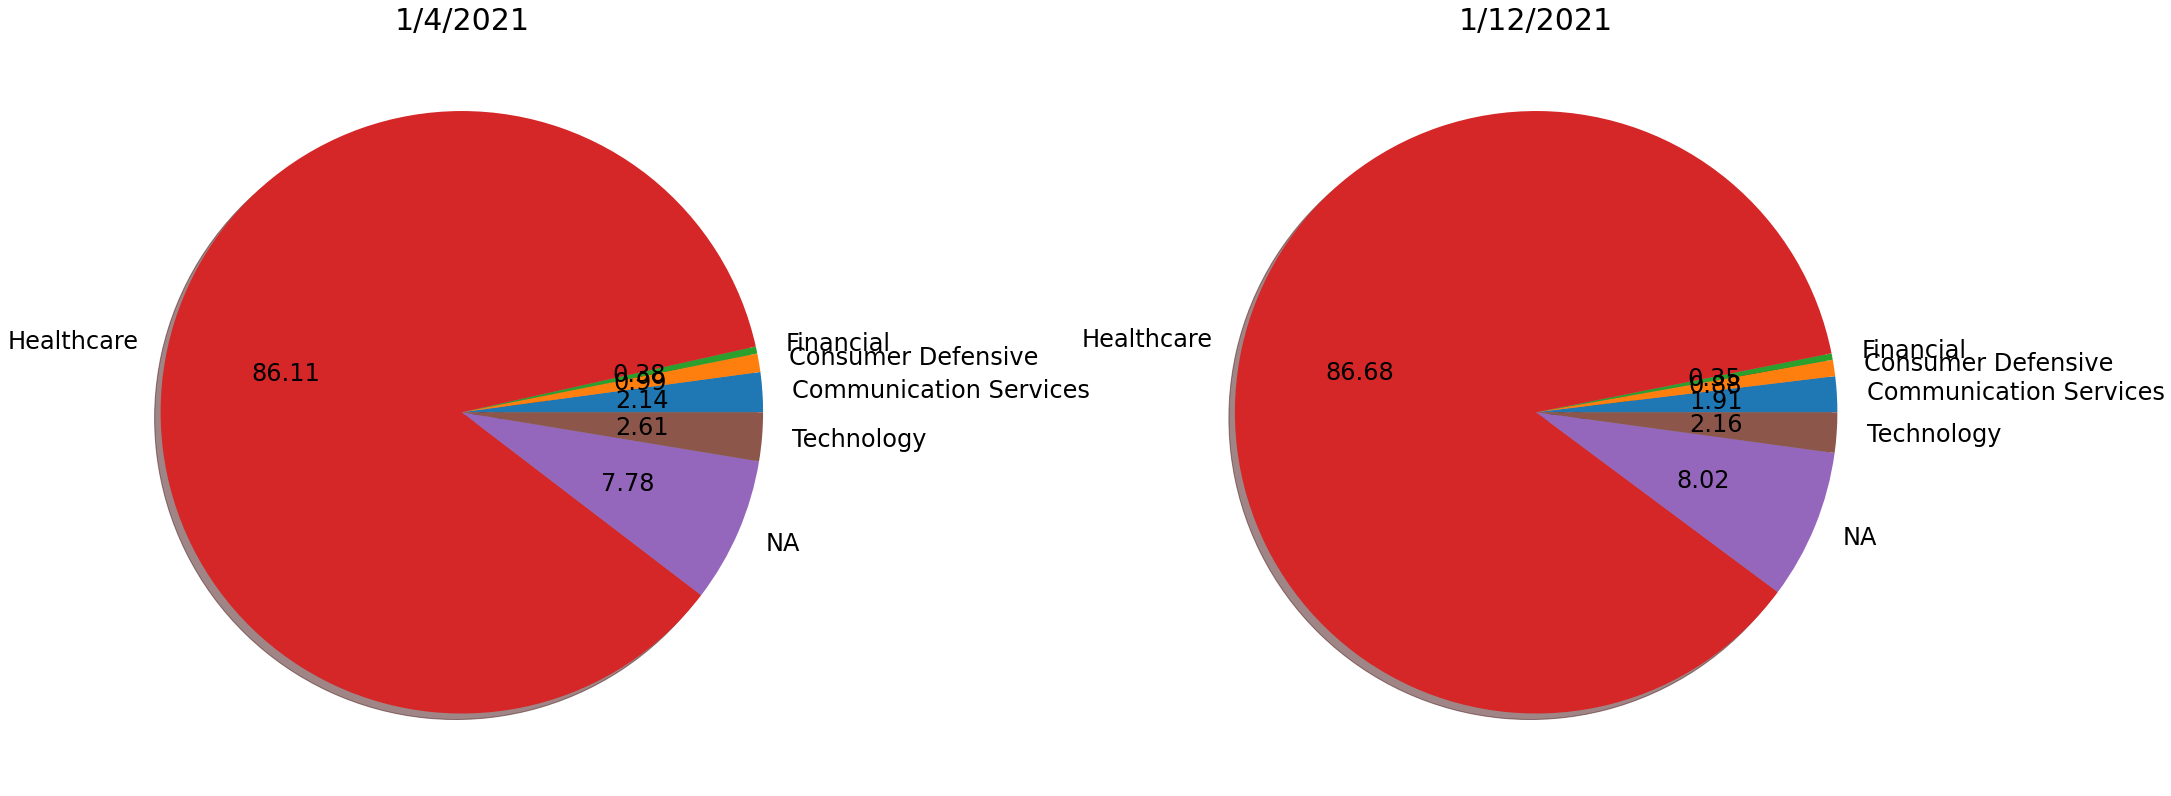

In [34]:
def portfolio_diff(date1,date2,fund="ARKG"):
    '''
    Get a snapshot difference between 2 differing portfolio dates
    
    date1 = initial date
    date2 = final date
    fund = which of the 5 ark funds (ARKQ,ARKW,ARKK,ARKF,ARKG)
    '''
    
    if len(date1)<6:
        date1 += "/2021"
    if len(date2)<6:
        date2 += "/2021"
    
    subset1 = df[(df['fund']==fund) & (df['date']==date1)]
    subset2 = df[(df['fund']==fund) & (df['date']==date2)]

    sectors = subset1['sector'].append(subset2['sector']).unique() #Unique sectors among the 2 requested queries

    subset2_diversity = subset2.groupby('sector').sum()['weight']

    def autopct_layout(val):
        import numpy as np
        return np.round(val,2)

    def pie_chart(subset,date):
        import matplotlib.pyplot as plt
        subset_diversity = subset.groupby('sector').sum()['weight']
        patches, texts, autotexts =  plt.pie(subset_diversity,labels=subset_diversity.index.to_list(),autopct=autopct_layout,shadow=True)
        for i in texts:
            i.set_fontsize(24) #Set font size of sector names
        for i in autotexts: 
            i.set_fontsize(24) #Set font size for the values
        plt.tight_layout()
        plt.title(str(date),fontsize=30)
        return subset_diversity

    import matplotlib.pyplot as plt
    import numpy as np
    plt.figure(figsize=(30,15))
    plt.subplot(1,2,1)
    a = pie_chart(subset1,date1)
    plt.subplot(1,2,2)
    b = pie_chart(subset2,date2)
    print("Change in sector investments comparing %s to %s (Negative = devesting out-of/ Positive = investing into)"%(date1,date2))
    display(b-a)
    return a,b #Return the differing portfolios

a,b = portfolio_diff('1/4',"1/12","ARKG")

# Ticker Lookup

With all this data, it would be nice to visualize ARK's stance in a position. Are they buying? Selling? How many shares?

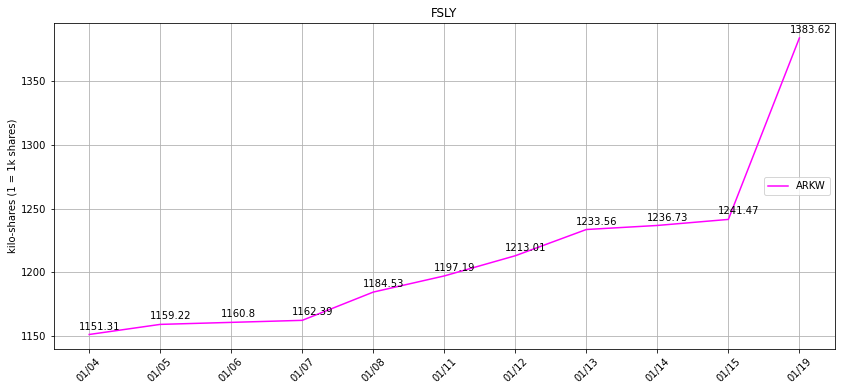

In [16]:
def ticker_lookup(tickers,together=True,funds=None):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import pandas as pd
    import datetime
    import numpy as np
    
    df = see_data() #Grab all data in ARKFund.db
    df['date'] = df['date'].astype('datetime64[ns]') #Convert date to datetime object so data can be sorted
    df = df.sort_values(['date','fund'],ascending=True) #Sort by ascending date

    #Compute a date axis
    earliest_date = df.iloc[0]['date']
    latest_date = df.iloc[-1]['date']
    xrange = pd.date_range(earliest_date,latest_date).date #Create a range of dates between start and end
    xrange = [datetime.datetime.strftime(i,"%m/%d/%Y") for i in xrange] #Convert datetime object to string "01/04/2021"
    
    plot_count = len(tickers) #How many plots per fund
    
    colors = ['magenta','k','cyan','g','r','dark green','pink','orange','yellow'] #Color pallete choices

    if funds == None: #If no fund is provided, search all 5 funds
        funds = ["ARKF","ARKG","ARKK","ARKQ","ARKW"]

    def log_reduction(val): #Reduce the y-axis by a factor of X
        import numpy as np
        reduced = [np.round(i/1000,2) for i in val] #Reduce share size by factor of 1000
        return reduced
    def timestamp_to_MonthDay(lst): #Convert "2021-01-14 00:00:00" to "01/14" for all elements in a list
        return [i.strftime("%m/%d") for i in lst]
    
    fund_label = []
    dates_vals = []
    if together:
        all_df = pd.DataFrame()
        i = 1

        for ticker in tickers:

            subset = df[df['ticker']==ticker.upper()].groupby('fund')
            plt.figure(figsize=(14,6))
            #plt.subplot(1,plot_count,i) #This would stack plots horizontally ... the above does it veritcally
            j = 0

            for _,r in subset:
                shares = log_reduction(r['shares'])
                fund_label.append(r['fund'].unique()[0])
                dates = np.arange(0,len(shares)) #Create an arbitrary date axis from [0,n]
                if len(dates_vals) < len(dates): #If a fund opened a new position in a ticker ... it would start plotting at the beginning of time
                    dates_vals = dates #This sets the x-axis to be maximized correctly
                    dates_labels = timestamp_to_MonthDay(r['date']) #This converts the correct x-axis from [0,1,2,...,n] to appropriate labels
                else: #This case would be specifically if a fund opens a new position in the fund
                    dates = np.arange(len(dates_vals)-len(dates),len(dates_vals)) #The fund will not span the [0,1,2,...,n], but instead some [m,m+1,...,n]
                plt.plot(dates,shares,label=ticker,color=colors[j])
                for idx,Y in enumerate(shares):
                    plt.annotate(str(Y),xy=(dates[idx],Y),xytext=(-10,5),textcoords='offset points')
                j += 1
                all_df = all_df.append(r) #df to return in case its useful
                
            plt.title(ticker.upper())
            plt.xticks(dates_vals,rotation=45,labels=dates_labels) #Feed the arbirary axis with labels as the dates
            #plt.yticks([]) #Hide y-axis (already have the numbers on the data points) -- might turn this into a feature
            #For shared plot ... need y-axis and legend on all figures
            plt.ylabel("kilo-shares (1 = 1k shares)")
            plt.legend(labels=fund_label,loc="center right")
            plt.grid(axis='both')
            i += 1
    else:
        all_df = pd.DataFrame()
        i = 1
        plt.figure(figsize=(14,6))
        plot_count = len(funds) #How many plots per fund

        for fund in funds:

            subset = df[df['fund']==fund.upper()]
            plt.subplot(1,plot_count,i)
            j = 0

            for ticker in tickers:
                r = subset[subset['ticker']==ticker.upper()]
                shares = log_reduction(r['shares'])
                dates = np.arange(0,len(shares)) #Create arbitrary date axis
                plt.plot(dates,shares,label=fund,color=colors[j])
                plt.xticks(dates_label,rotation=45,labels=dates_vals) #Feed in arbirary axis with labels as the dates
                for idx,Y in enumerate(shares):
                    plt.annotate(str(Y),xy=(idx,Y),xytext=(-10,5),textcoords='offset points')
                j += 1
                all_df = all_df.append(r) #df to return in case its useful

            plt.title(fund.upper())
            #plt.yticks([])
            plt.grid(axis='y')
            plt.tight_layout()
            if i == 1:
                plt.ylabel("kilo-shares (1 = 1k shares)")
            if i == plot_count:
                plt.legend(labels=tickers,loc="center right")
            i += 1
    return all_df
a = ticker_lookup(tickers = ['FSLY'],together=True)

Lets convert this to an app! (1/17 comment -- Currently this is just a skeleton)

In [62]:
%%writefile app.py
import dash
import plotly
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output, State

#Load in dash app with external CSS elements
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

#Define some theme settings
colors = {
    'background': '#111111',
    'text': '#7FDBFF',
    'button':'#D6D8DC'
    }

app.layout = html.Div([
    html.Div(
        className="app-header",
        children=[
            html.Div('Plotly Dash', className="app-header--title")
        ]
    ),
    html.Div(
        children=html.Div([
            html.H5('Overview'),
            html.Div('''
                This is an example of a simple Dash app with
                local, customized CSS.
            ''')
        ])
    )
]) #Close app.layout

if __name__ == '__main__':
    app.run_server(debug=True,port=8050)

Writing app.py
